In [ ]:
# @title Tải Dataset CIFAR-10

from google.colab import files
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle
import tarfile

!mkdir -p cifar10_data

# Giải nén tệp tar.gz
with tarfile.open('/content/drive/MyDrive/KHDL/cifar-10-python.tar.gz', 'r:gz') as tar:
    tar.extractall(path='cifar10_data')

print("Extraction completed to 'cifar10_data'")
!ls -la cifar10_data/cifar-10-batches-py/

Extraction completed to 'cifar10_data'
total 181884
drwxr-xr-x 2 2156 1103     4096 Jun  4  2009 .
drwxr-xr-x 3 root root     4096 Apr 16 02:28 ..
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_batch(file):
    data_dict = unpickle(file)
    data = data_dict[b'data']
    labels = data_dict[b'labels']
    data = data.reshape(data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

def load_cifar10_from_files(data_folder='cifar10_data/cifar-10-batches-py'):
    X_train = []
    y_train = []

    for i in range(1, 6):
        data, labels = load_batch(f'{data_folder}/data_batch_{i}')
        X_train.append(data)
        y_train.extend(labels)

    X_train = np.concatenate(X_train)
    y_train = np.array(y_train)

    # Tải dữ liệu kiểm tra
    X_test, y_test = load_batch(f'{data_folder}/test_batch')
    y_test = np.array(y_test)

    # Tải tên các lớp
    meta_dict = unpickle(f'{data_folder}/batches.meta')
    class_names = [label.decode('utf-8') for label in meta_dict[b'label_names']]

    return X_train, y_train, X_test, y_test, class_names

# Load dữ liệu
X_train, y_train, X_test, y_test, class_names = load_cifar10_from_files()

# Kiểm tra
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Class names: {class_names}")


X_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000,)
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
def one_hot_encoding(labels):
    unique_labels = sorted(list(set(labels)))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    n_samples = len(labels)
    n_classes = len(unique_labels)
    encoded = np.zeros((n_samples, n_classes), dtype=int)

    for i, label in enumerate(labels):
        encoded[i, label_to_index[label]] = 1

    return encoded

Resized X_train shape: (50000, 64, 64, 3)
Resized X_test shape: (10000, 64, 64, 3)
Train X shape: (40000, 64, 64, 3)
Train y shape: (40000, 10)
Validation X shape: (10000, 64, 64, 3)
Validation y shape: (10000, 10)
Test X shape: (10000, 64, 64, 3)
Test y shape: (10000, 10)


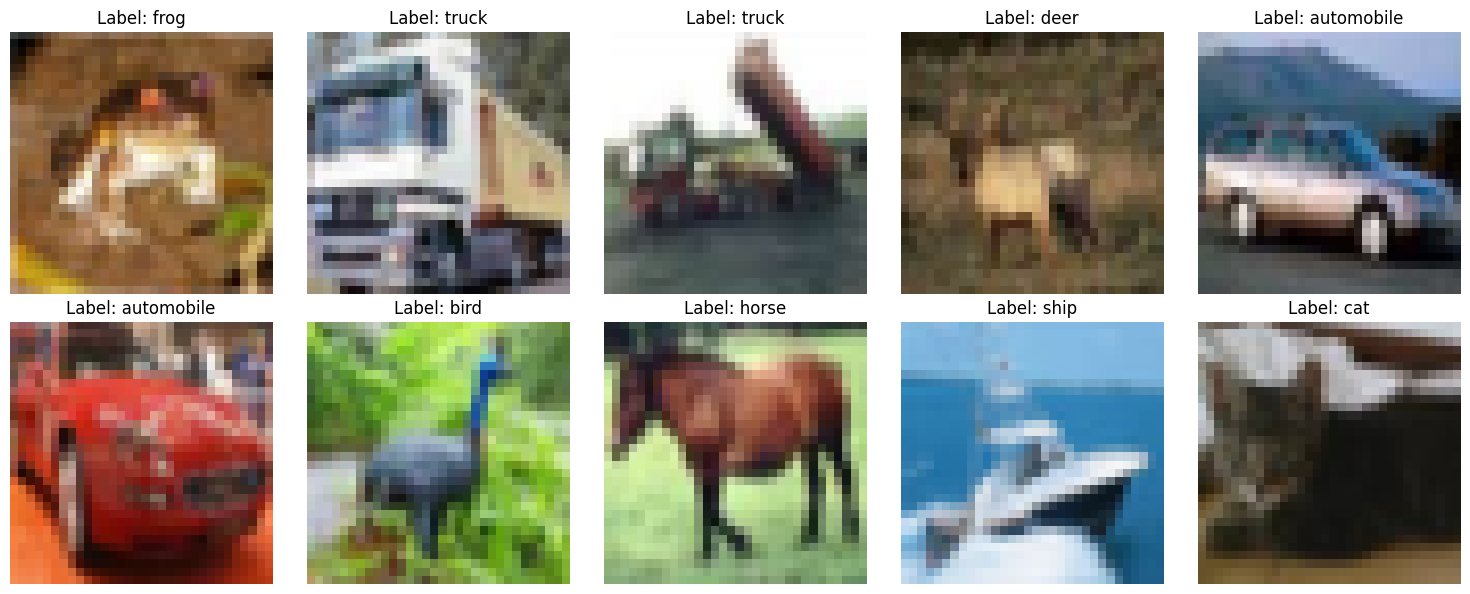

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation và resize
data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

def resize_images(images, target_size=(64, 64)):
    resized_images = np.zeros((images.shape[0], target_size[0], target_size[1], 3))
    for i, img in enumerate(images):
        resized_images[i] = tf.image.resize(img, target_size).numpy()
    return resized_images

# Resize hình ảnh
X_train_resized = resize_images(X_train)
X_test_resized = resize_images(X_test)

print(f"Resized X_train shape: {X_train_resized.shape}")
print(f"Resized X_test shape: {X_test_resized.shape}")

# Chuẩn hóa [0, 1]
X_train_resized = X_train_resized.astype('float32') / 255.0
X_test_resized = X_test_resized.astype('float32') / 255.0

# One-hot encoding
y_train = one_hot_encoding(y_train)
y_test = one_hot_encoding(y_test)

num_labels = y_train.shape[1]

# Chia tập validation
validation_split_ratio = 0.2
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train_resized, y_train, test_size=validation_split_ratio, random_state=42, stratify=y_train
)

print(f"Train X shape: {X_train_new.shape}")
print(f"Train y shape: {y_train_new.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")
print(f"Test X shape: {X_test_resized.shape}")
print(f"Test y shape: {y_test.shape}")

# Hiển thị một số hình ảnh mẫu
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(X_train[i])  # Hiển thị ảnh gốc không resize
    axes[i].set_title(f'Label: {class_names[np.argmax(y_train[i])]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

def create_alexnet_model(input_shape=(64, 64, 3), num_classes=10):
    model = Sequential(name='AlexNet-CIFAR10')

    # Layer 1
    model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu',
                    input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Layer 2
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Layer 3
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))

    # Layer 4
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))

    # Layer 5
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Flatten + Fully Connected Layers
    model.add(Flatten())

    # Layer 6
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Tạo mô hình
model = create_alexnet_model(input_shape=(64, 64, 3), num_classes=10)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "AlexNet-CIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,769,290 (94.49 MB)

 Trainable params: 24,768,586 (94.48 MB)

 Non-trainable params: 704 (2.75 KB)

#### Biên dịch mô hình (Compile)

In [ ]:
# Accuracy monitoring
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint_filepath = '/content/checkpoints/alexnet_cifar10_epoch-{epoch:02d}-val_acc-{val_accuracy:.4f}.weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1)

In [ ]:
!mkdir -p /content/checkpoints
!mkdir -p /content/models


#### Huấn luyện mô hình (Train/Fit)

In [ ]:
print("\nBắt đầu huấn luyện mô hình...")
history = model.fit(
    data_generator.flow(X_train_new, y_train_new, batch_size=64),
    epochs=25,
    steps_per_epoch=len(X_train_new) // 64,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint_callback, reduce_lr])
print("Huấn luyện hoàn tất.")


Bắt đầu huấn luyện mô hình...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2659 - loss: 2.0167
Epoch 1: val_accuracy improved from -inf to 0.40660, saving model to /content/checkpoints/alexnet_cifar10_epoch-01-val_acc-0.4066.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 107ms/step - accuracy: 0.2661 - loss: 2.0163 - val_accuracy: 0.4066 - val_loss: 1.6909 - learning_rate: 0.0010
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4483 - loss: 1.5387
Epoch 2: val_accuracy improved from 0.40660 to 0.48260, saving model to /content/checkpoints/alexnet_cifar10_epoch-02-val_acc-0.4826.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 102ms/step - accuracy: 0.4483 - loss: 1.5386 - val_accuracy: 0.4826 - val_loss: 1.5115 - learning_rate: 0.0010
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5126 - loss: 1.3836
Epoch 3: val_accuracy improved from 0.48260 to 0.54050, saving model to /content/checkpoints/alexnet_cifar10_epoch-03-val_acc-0.5405.weights.h5
625/625 ━━━━━━━━━━━━━━

#### Đánh giá mô hình (Evaluate)

In [ ]:
print("\nĐánh giá mô hình trên tập kiểm tra:")
loss, accuracy = model.evaluate(X_test_resized, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Đồ thị Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Đồ thị Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


#### Tải lại trọng số từ checkpoint tốt nhất và đánh giá lại

In [ ]:
# Tìm file checkpoint tốt nhất
import glob
import re

checkpoint_dir = os.path.dirname(checkpoint_filepath)

list_of_checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'alexnet_cifar10_epoch-*-val_acc-*.weights.h5'))

if list_of_checkpoint_files:
    best_checkpoint_path = ""
    best_val_accuracy = -1.0

    for file_path in list_of_checkpoint_files:
        match = re.search(r"val_acc-(\d+\.\d+)\.weights\.h5$", os.path.basename(file_path))
        if match:
            current_val_accuracy = float(match.group(1))
            if current_val_accuracy > best_val_accuracy:
                best_val_accuracy = current_val_accuracy
                best_checkpoint_path = file_path

    if best_checkpoint_path:
        print(f"\nLoading best checkpoint: {best_checkpoint_path} (Val Acc: {best_val_accuracy:.4f})")

        model.load_weights(best_checkpoint_path)

        print("Re-evaluate best checkpoint")
        loss, accuracy = model.evaluate(X_test_resized, y_test, verbose=0)
        print(f'Test Loss: {loss:.4f}')
        print(f'Test Accuracy: {accuracy:.4f}')

        output_path = f"/content/models/cifar10-alexnet-{accuracy:.4f}.keras"
        model.save(output_path, overwrite=True)
        print(f"Model saved to {output_path}")
    else:
        print("\nNo checkpoint with matches filename found")
else:
    print("\nNo checkpoint found in folder")

def plot_sample_predictions(model, X, y, class_names, num_samples=10):
    # Lấy ngẫu nhiên một số mẫu
    indices = np.random.choice(len(X), num_samples, replace=False)
    X_samples = X[indices]
    y_true = np.argmax(y[indices], axis=1)

    # Dự đoán
    y_pred_probs = model.predict(X_samples)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Vẽ
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        axes[i].imshow(X_samples[i].reshape(64, 64, 3))
        color = 'green' if y_pred[i] == y_true[i] else 'red'
        axes[i].set_title(f'True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}', color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_predictions(model, X_test_resized, y_test, class_names)

#### Dự đoán một ảnh

In [ ]:
from google.colab import files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Chỉ tìm model trong thư mục
import glob

model_files = glob.glob("/content/models/cifar10-alexnet-*.keras")
if model_files:
    # Sắp xếp theo thời gian tạo để lấy file mới nhất
    model_path = max(model_files, key=os.path.getctime)
    print(f"Loading model from {model_path}")
    model = tf.keras.models.load_model(model_path)
else:
    print("No model file found, using current model")


Tải lên hình ảnh để dự đoán (hình ảnh màu 32x32 pixel):


Saving skynews-boeing-737-plane_5435020.jpg to skynews-boeing-737-plane_5435020.jpg
User uploaded file "skynews-boeing-737-plane_5435020.jpg" with length 66774 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


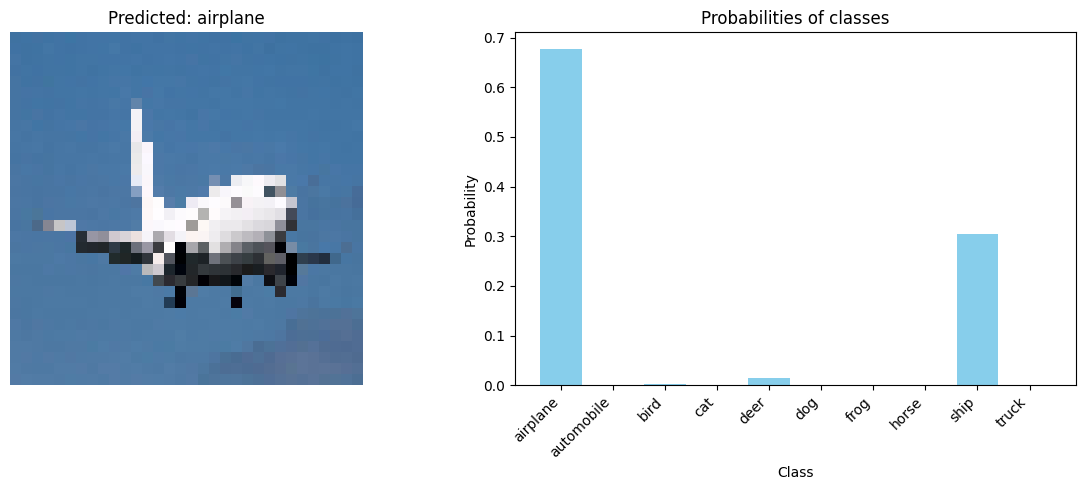

In [ ]:
print("\nTải lên hình ảnh để dự đoán (hình ảnh màu sẽ được resize thành 64x64 pixel):")
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    try:
        img = tf.keras.preprocessing.image.load_img(fn, target_size=(64, 64))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img_array[0])
        predicted_class = np.argmax(predictions[0])
        plt.title(f"Predicted: {class_names[predicted_class]}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.bar(class_names, predictions[0], color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.title('Probabilities of classes')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing image: {e}")

!rm -rf {fn}